<a href="https://colab.research.google.com/github/satuelisa/CINVESTAV2025/blob/main/insight.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Hide and seek

Today we will learn about how machine learning works by creating data that we know to follow certain patterns and then using computational methods to "rediscover" the rules.

Let's assume that the phenomenon we are interested in has three aspects that are easy for us to observe and measure. We shall keep those aspects as abstract as possible so everyone can think of them in terms of something you would measure in your laboratory or field work.

Thing `one` will be easy to measure precisely since we simply count how many of something we can see.

Thing `two` is measured with much detail and high precision, although the measurement may have an inherent bias (imagine something being weighed on a scale, for example). This one is exponentially distributed (often very small, sometimes rather big).

Thing `three` is hard to measure and the measurements are often noisy. The aspect we try to measure is normally distributed and the measurement noise is uniformly distributed.

Let's refer to the object our interest, another quantifiable aspect of the phenomenon of study as `target` (you can imagine this to be the lifetime of an organism if you'd like).

We will create synthetic data in which `target` depends *linearly* but *inversely* on thing `one` (the bigger the value of `one`, the smaller the value of `target`), independent of `two` (the value of `two` has no clear effect on the value of `target`), and quadratically on thing `three` (the bigger `three` is, the bigger is `target` but this "speeds up" as `three` increases). We will pretend we know none of these three rules and attempt to discover them computationally.

In [ ]:
from random import randint, uniform
import numpy as np
import pandas as pd

n = 1000 # how many observations in total

constant = 12.3
am1 = -0.123 # arbitrary multiplier for the inverse lineal relationship
am3 = 4.321 # arbitrary multiplier for the quadratic relationship

data = []

for i in range(n):
  one = randint(2, 12) # we observe no fewer than two but no more than a dozen of the countable things
  two = np.random.exponential(5.4) # we observe the easy-to-measure thing (that will not have any effect)
  three = np.random.normal(12.3, 1.4) + uniform(0.1, 0.3) # a normal distribution and uniform additive noise
  target = constant + am3 * three**2 + am1 * one + np.random.normal(0, 1) # our "formula" and some noise
  data.append([one, two, three, target])

dataset = pd.DataFrame(data, columns = ['one', 'two', 'three', 'target'])
dataset.shape

In [ ]:
dataset.head()

In [ ]:
import seaborn as sns

sns.pairplot(dataset)

Assume we want to "explain" `target` in terms of `one`, `two` and `three` so that if we know the latter, we can "predict" or "estimate" the former. This makes the latter triplet our "observed features" and `target` is the thing we seek to model in terms of these features.

Notice how the curve for three versus target is a bit curvy. When this happens, we need to try to *transform* that value into something that would make a line instead, whenever possible.

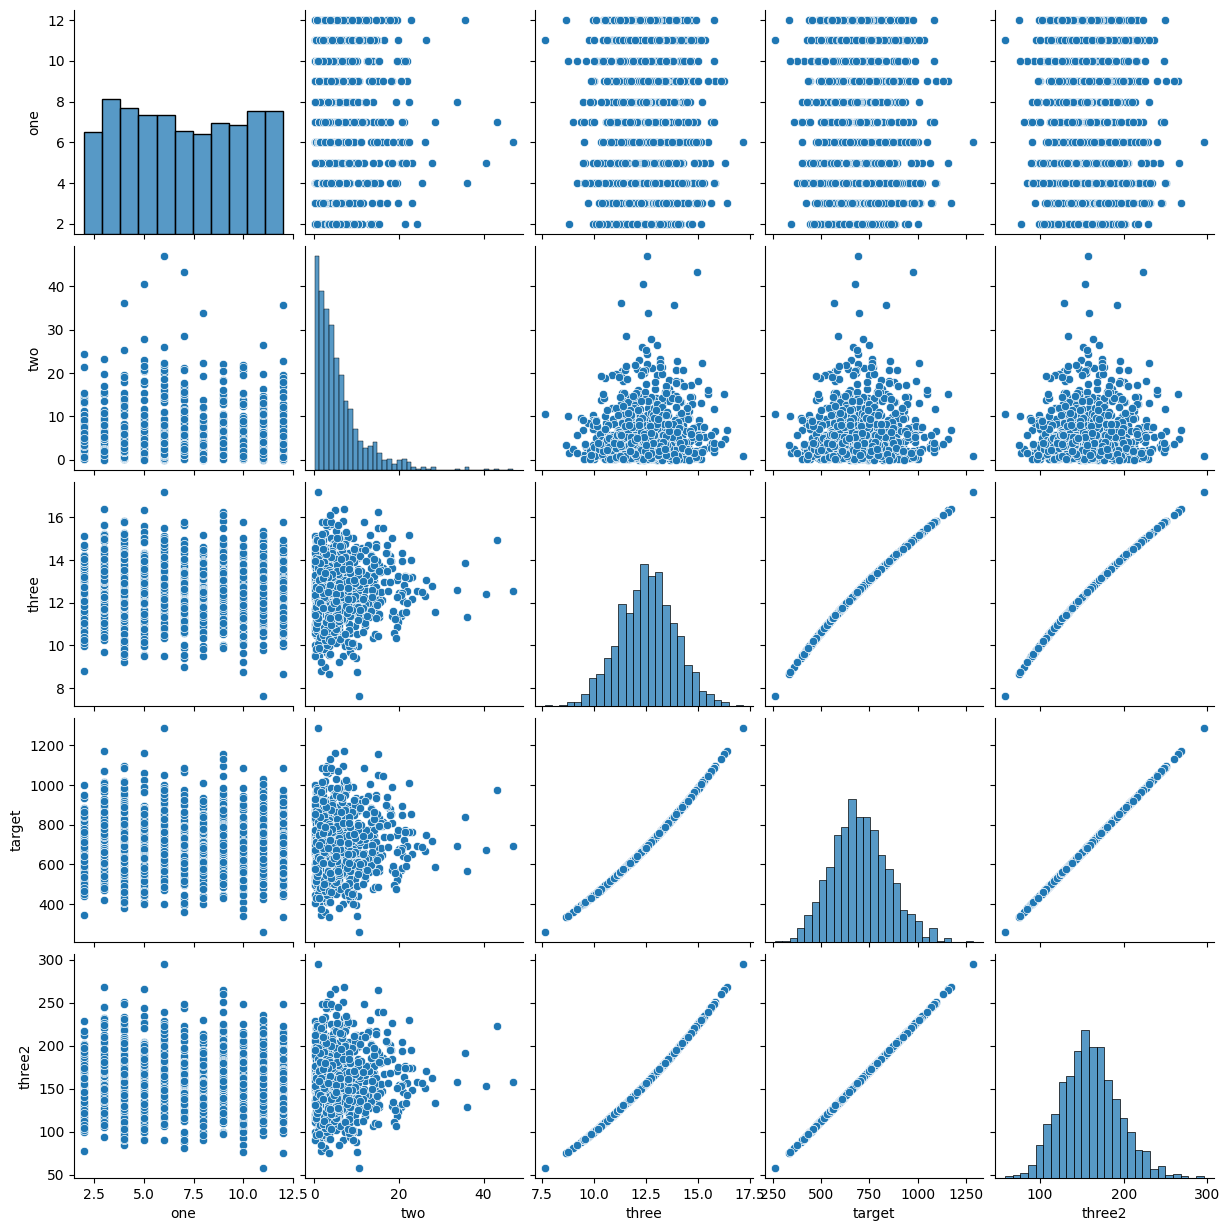

In [16]:
dataset['three2'] = np.square(dataset.three)
sns.pairplot(dataset)

Since it is much better of a line now, we will ditch `three` and just work with `three2` from hereon.

In [17]:
improved = dataset.drop('three', axis = 1)

In [18]:
response = improved.target.to_numpy() # arrays are like lists, but for math
print(len(response))
print(response[:5])

1000
[916.37218844 824.09970774 518.49405304 633.82513018 496.4707964 ]


In [19]:
others = improved.drop('target', axis = 1) # we need to separate the "response" from the "features" so we can train models
print(others.shape)
features = others.to_numpy() # this is a 2D array
print(features.shape)

(1000, 3)
(1000, 3)


In [20]:
from sklearn.linear_model import LinearRegression # first things first: start with a regression model

model = LinearRegression()
model.fit(features, response)
print(model.score(features, response)) # is it good?
coef = model.coef_ # model coefficients
print(' '.join([ f'{c:.3f}' for c in coef] ))
print(f'reminder: we expect {am1:.3f} for one, zero for two, and {am3:.3f} for three SQUARED')
print(f'we expect an intercept {constant} and got {model.intercept_:.2f}')

0.9999547899393985
-0.112 -0.002 4.320
reminder: we expect -0.123 for one, zero for two, and 4.321 for three SQUARED
we expect an intercept 12.3 and got 12.36


In [31]:
testdata = [] # fresh

for i in range(n): # same logic
  one = randint(12, 50) # we observe no fewer than two but no more than a dozen of the countable things
  two = np.random.exponential(5.4) # we observe the easy-to-measure thing (that will not have any effect)
  three = np.random.normal(15.1, 1.7) + uniform(0.1, 0.8) # a normal distribution and uniform additive noise
  target = constant + 10 * two + (am3 + 0.1) * three**2 + am1 * one + np.random.normal(0, 1) # our "formula" and some noise
  testdata.append([one, two, three, target])

d2 = pd.DataFrame(testdata, columns = ['one', 'two', 'three', 'target'])
d2['three2'] = np.square(d2.three)
better = d2.drop('three', axis = 1)
y = better.target.to_numpy()
o = better.drop('target', axis = 1)
X = o.to_numpy()
print(y.shape, X.shape, model.score(X, y))

(1000,) (1000, 3) 0.8519676696413712


If we can make predictions and find explanations with "just" a regression model, we should **never** seek to complicate things and throw in machine learning of other flavors. The **simplest** model that *works* is always the one that a Real Scientist is the happiest with.

Now, let's imagine a case that is more complex.

Suppose that we have those same features but with a different formula that involves *thresholds*.

In [45]:
from math import log

# threshold
t1 = 5
t2 = 10

data2 = []

for i in range(n):
  one = randint(2, 12)
  two = np.random.exponential(5.4)
  target = two < t2 and one > t1 # we condition the value of target with thresholds to get a true/false result
  data2.append([one, two, target])

d2 = pd.DataFrame(data2, columns = ['one', 'two', 'target'])
d2.head()
sum(d2.target)

523

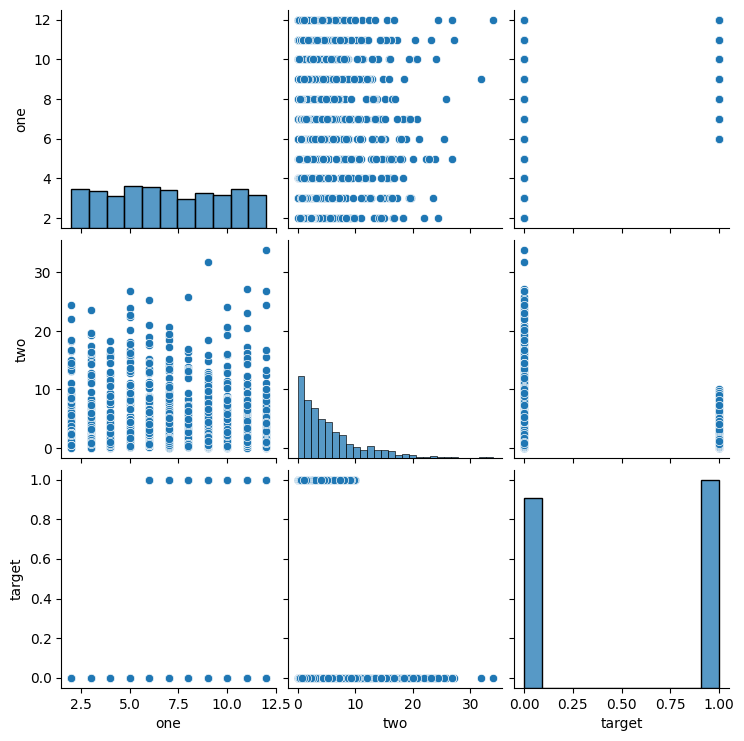

In [46]:
sns.pairplot(d2)

The next simplest option is generally a [*decision tree*](https://scikit-learn.org/stable/modules/tree.html#tree).

We will begin to denote the response as `y` and the feature matrix as `X` since this is the usual notation in the literature.

In [48]:
y = d2.target.to_numpy()
o = d2.drop('target', axis = 1)
X = o.to_numpy()

Decision-tree models are *trained* very similarly to what we did with linear regression above.

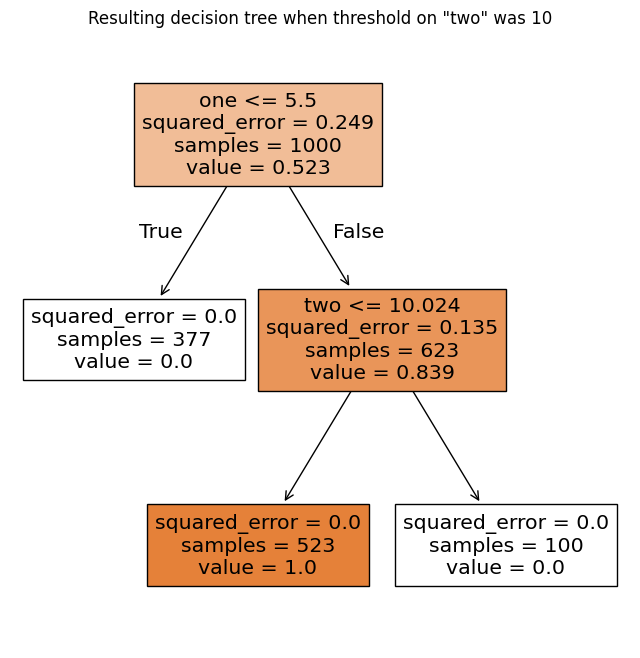

In [50]:
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn import tree
t = tree.DecisionTreeRegressor().fit(X, y)

plt.subplots(figsize = (8, 8))
names = [ 'one', 'two' ]
tree.plot_tree(t, filled = True, feature_names = names)
plt.title(f'Resulting decision tree when threshold on "two" was {t2}')
plt.show()

Now, try to think of research data you have worked with that would be suitable for linear or tree regression models. After the break, we look at generalizations of what we just did with the tree and the true/false labels.

## Clustering versus classification

Clustering = discovery of groups within data based on (dis)similarities within the features.

Classification = given a set of pre-labeled data (each feature vector is assigned a group label), determine which of those labels should apply to new unlabeled data.

Let's start with the former creating feature vectors representing colored dots on a plane. in which the features are 2D-coordinates, color (in three channels, RGB) and size (diameter).

In [86]:
from random import randint, uniform
from math import log, fabs
import numpy as np

n = 1000

maxsize = 50
minsize = 3

dots = []
for i in range(n):

  # size
  s = minsize + ((uniform(2, 5) + np.random.exponential(15)) % maxsize)

  # color
  R = randint(100, 255)
  G = randint(0, 255)
  B = randint(0, 255)

  color = '#{:02x}{:02x}{:02x}'.format(R, G, B) # redundant as a feature, useful for drawing

  # position  in function of the colors
  x = uniform(s / 4, s / 2) - np.random.normal(R, log(R + 10)) + np.random.normal(255 - G, log(G + 10))
  y = np.random.normal(x // 5, log(s, 2)) * np.random.normal(B // 2, log(B + 10))
  diff = x - y
  threshold = min(x, y) // 5
  if diff < -threshold:
    y += np.random.normal(1, log(fabs(x) + 1))
  elif diff > threshold:
    x -= np.random.normal(1, log(fabs(y) + 1))
  else:
    x += uniform(-5, 5)
    y += uniform(-5, 5)
  norms = (s - minsize) / maxsize

  dots.append([x, y, R/255, G/255, B/255, s, norms, color])

dd = pd.DataFrame(dots, columns = ['x', 'y', 'R', 'G', 'B', 's', 'norms', 'color'])
dd.head()

,x,y,R,G,B,s,norms,color
0,-77.131369,-551.334432,0.827451,0.537255,0.274510,16.660962,0.273219,#d38946
1,-24.513719,-658.116814,0.968627,0.156863,0.803922,7.216611,0.084332,#f728cd
2,-156.341931,-3824.384008,0.690196,0.949020,0.898039,14.453722,0.229074,#b0f2e5
3,68.490141,104.119305,0.733333,0.011765,0.094118,26.116969,0.462339,#bb0318
4,-67.364694,-556.219363,0.835294,0.525490,0.356863,31.257270,0.565145,#d5865b


Let's look at these dots.

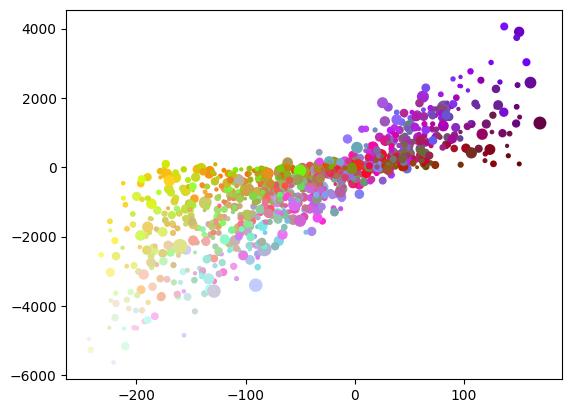

In [77]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.scatter(dd.x, dd.y, s = dd.s, c = dd.color)
plt.show()

The human eye can now catch some patterns there as per color and size. Let's see if the computational models can do this, too.

In [98]:
from sklearn.cluster import KMeans

minx = min(dd.x)
maxx = max(dd.x)
miny = min(dd.y)
maxy = max(dd.y)
normx = dd.x - minx
normy = dd.y - miny
dd['nx'] = normx / (maxx - minx)
dd['ny'] = normy / (maxy - miny)

f1 = dd.drop('color', axis = 1) # the "color" column was just for drawing
f2 = f1.drop('norms', axis = 1)
f3 = f2.drop('x', axis = 1)
f4 = f3.drop('y', axis = 1)
X = f4.to_numpy()

# we have to say how many groups we want
howMany = 6

kmeans = KMeans(n_clusters = howMany).fit(X)

groups = kmeans.labels_
print(groups[:20])

[0 2 4 3 5 2 2 4 4 5 2 5 3 4 2 4 3 3 2 3]


How to see this? Let's change the dots into different kinds of symbols according to the cluster labels.

In [99]:
dd['cluster'] = groups
dd.head()

,x,y,R,G,B,s,norms,color,cluster,nx,ny
0,-77.131369,-551.334432,0.827451,0.537255,0.274510,16.660962,0.273219,#d38946,0,0.441129,0.534832
1,-24.513719,-658.116814,0.968627,0.156863,0.803922,7.216611,0.084332,#f728cd,2,0.569236,0.523852
2,-156.341931,-3824.384008,0.690196,0.949020,0.898039,14.453722,0.229074,#b0f2e5,4,0.248276,0.198279
3,68.490141,104.119305,0.733333,0.011765,0.094118,26.116969,0.462339,#bb0318,3,0.795671,0.602230
4,-67.364694,-556.219363,0.835294,0.525490,0.356863,31.257270,0.565145,#d5865b,5,0.464908,0.534330


215
57
270
150
216
92


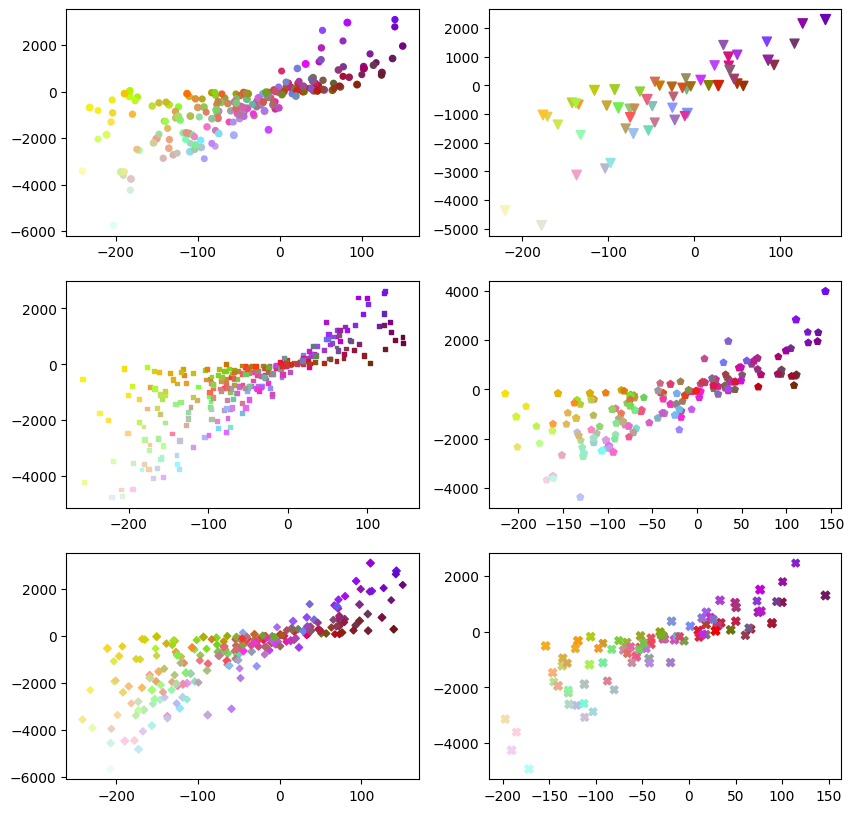

In [100]:
symbols = { 0 : 'o', 1 : 'v', 2 : 's', 3 : 'p', 4 : 'D', 5 : 'X', 6 : 'P' } # one extra

from math import sqrt, floor, ceil

rows = int(ceil(sqrt(howMany)))
cols = int(floor(howMany // rows))

while rows * cols < howMany:
  if rows * cols % 2 == 0:
    rows +=1
  else:
    cols += 1

fig, ax = plt.subplots(rows, cols, figsize = (10, 10))

row = 0
col = 0

for label, subset in dd.groupby('cluster'):
  print(len(subset))
  s = symbols.get(label, '.')
  ax[row, col].scatter(subset.x, subset.y, s = subset.s, c = subset.color, marker = s, label = s)
  col += 1
  if col == cols:
    row += 1
    col = 0

plt.show()

What do the groups seem to have in common internally and what makes them different from one another?

Play with how the data is generated and then investigate the impact of the number of clusters on the result.

### Supervised learning

As our last item today, we will investigate the most common case study known to mankind: [classification of hand-written digits](https://scikit-learn.org/stable/auto_examples/classification/plot_digits_classification.html). Given a set of images, each of which accompanied by a label of which digit is in that image, build a model that is able to take a whole new image and assign a label to that one.

In [101]:
from sklearn import datasets
digits = datasets.load_digits()
count = len(digits.images)
print(count)

1797


Let's look at a random one.

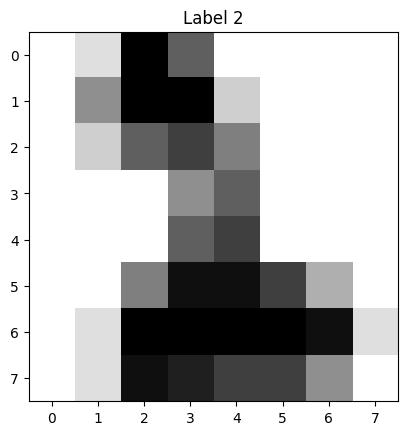

In [112]:
pickOne = randint(0, count - 1)
plt.imshow(digits.images[pickOne], cmap = plt.cm.gray_r, interpolation = 'nearest')
plt.title(f'Label {digits.target[pickOne]}')
plt.show()

We can train a **classifier**. We will *not* use *all* of our data to train it, but instead set some aside so we can test the trained model with images that it has not seen during training.

In [144]:
features = digits.images.reshape((count, -1)) # the 64 individual pixels will be our features
labels = digits.target
setAside = 0.3 # use 70% for training, 30% for testing

In [141]:
from sklearn import svm # support vector machine

model = svm.SVC()

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size = setAside)
model.fit(X_train, y_train)

SVC()

We can now feed the *other* images to the model and ask it to suggest labels for them.

In [145]:
output  = model.predict(X_test)

Let's look at a random one again.

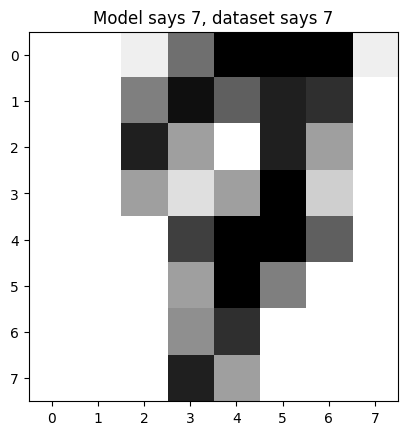

In [146]:
howMany = len(y_test)
pickOne = randint(0, howMany)

pixels = X_test[pickOne].reshape((8, 8))

plt.imshow(pixels, cmap = plt.cm.gray_r, interpolation = 'nearest')
plt.title(f'Model says {output[pickOne]}, dataset says {y_test[pickOne]}')
plt.show()

Does the model always agree what the intended ground truth?

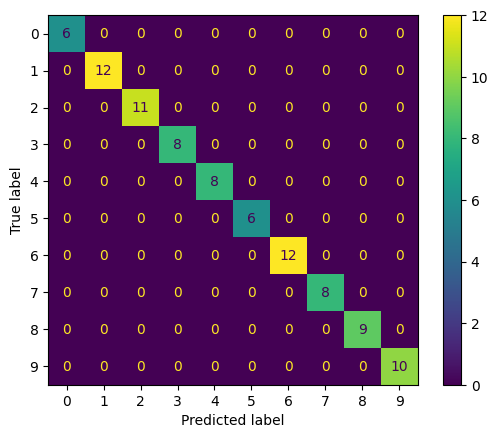

In [143]:
from sklearn import metrics

score = metrics.ConfusionMatrixDisplay.from_predictions(y_test, output)
plt.show()